## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [2]:
65 // 2

32

In [3]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [4]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [5]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [6]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [7]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [8]:
import segmentation_models_pytorch as smp

In [9]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [10]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp025a'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 2 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:299: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)


## helper

In [11]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [12]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [13]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [14]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [15]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [16]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    # mid = 65 // 2
    mid = 38 # https://www.kaggle.com/code/ajland/eda-a-slice-by-slice-analysis
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [17]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [18]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [19]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [20]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [21]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [22]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [23]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

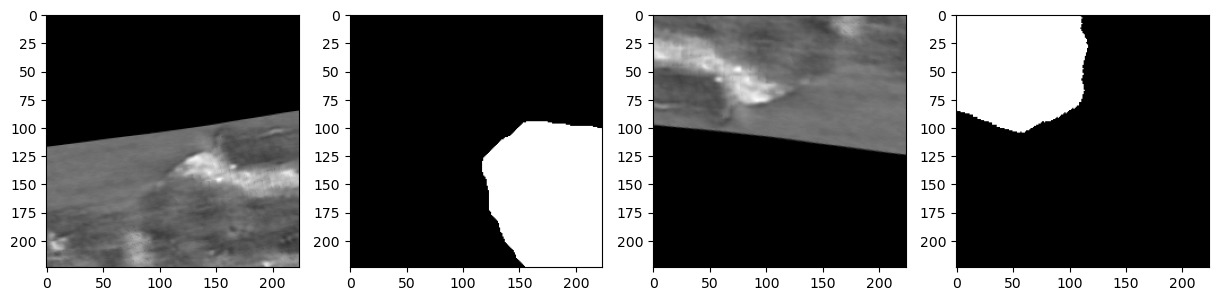

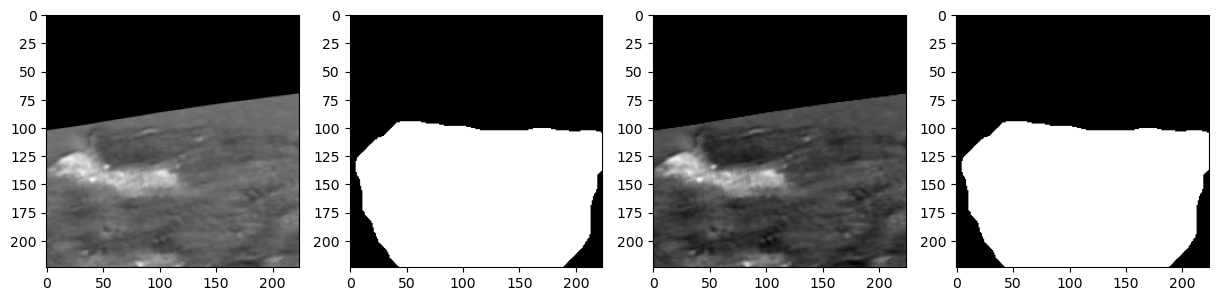

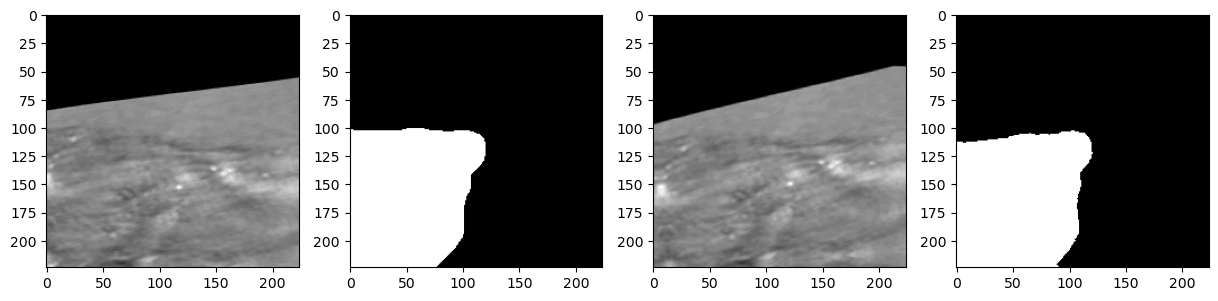

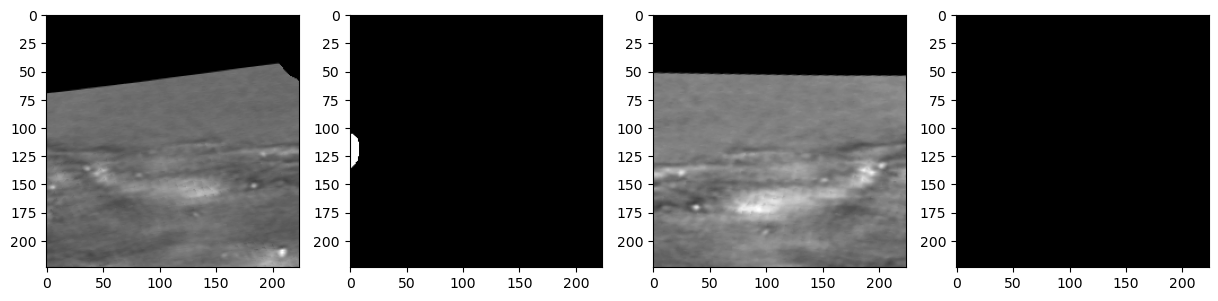

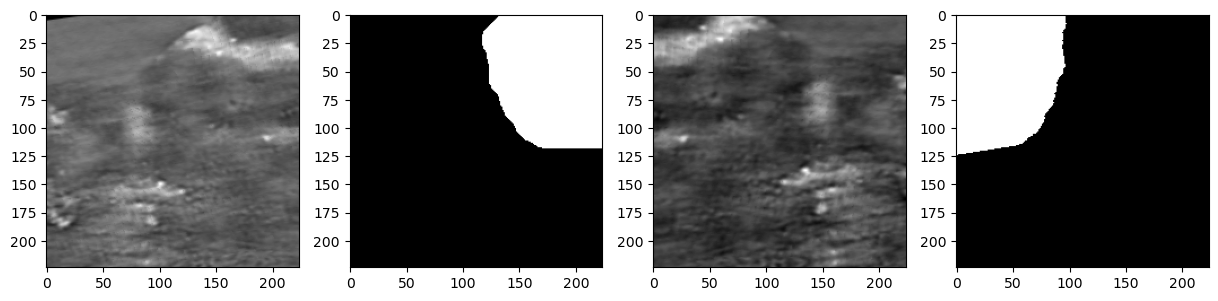

In [24]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [25]:
del plot_dataset
gc.collect()

48125

## model

In [26]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [27]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [28]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [29]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [30]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [31]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [32]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [33]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [34]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [35]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.14159891432990973
th: 0.15, fbeta: 0.1414175952691179
th: 0.2, fbeta: 0.14094366045600373
th: 0.25, fbeta: 0.14082919100388783
th: 0.3, fbeta: 0.19405414534999946
th: 0.35, fbeta: 0.20421654920963175
th: 0.4, fbeta: 0.20701561760324969
th: 0.45, fbeta: 0.20499314407931757


best_th: 0.4, fbeta: 0.20701561760324969
Epoch 1 - avg_train_loss: 0.6472  avg_val_loss: 0.5114  time: 121s
Epoch 1 - avgScore: 0.2070
Epoch 1 - Save Best Score: 0.2070 Model
Epoch 1 - Save Best Loss: 0.5114 Model


th: 0.5, fbeta: 0.18539888812439845


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14170022768576568
th: 0.15, fbeta: 0.1416867781134805
th: 0.2, fbeta: 0.19453378216025913
th: 0.25, fbeta: 0.20987144714399222
th: 0.3, fbeta: 0.22866963862778225
th: 0.35, fbeta: 0.20952971708414195
th: 0.4, fbeta: 0.1569135342423368
th: 0.45, fbeta: 0.09676887547506753


best_th: 0.3, fbeta: 0.22866963862778225
Epoch 2 - avg_train_loss: 0.4325  avg_val_loss: 0.4065  time: 121s
Epoch 2 - avgScore: 0.2287
Epoch 2 - Save Best Score: 0.2287 Model
Epoch 2 - Save Best Loss: 0.4065 Model


th: 0.5, fbeta: 0.04511456227701226


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.2296180689809084
th: 0.15, fbeta: 0.23136323856692484
th: 0.2, fbeta: 0.21482987354973854
th: 0.25, fbeta: 0.19387940486113756
th: 0.3, fbeta: 0.16717366717362453
th: 0.35, fbeta: 0.12468743376346736
th: 0.4, fbeta: 0.07683523725191882
th: 0.45, fbeta: 0.03621985670955166


best_th: 0.15, fbeta: 0.23136323856692484
Epoch 3 - avg_train_loss: 0.3090  avg_val_loss: 0.3380  time: 119s
Epoch 3 - avgScore: 0.2314
Epoch 3 - Save Best Score: 0.2314 Model
Epoch 3 - Save Best Loss: 0.3380 Model


th: 0.5, fbeta: 0.010663603212585538


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.1947632448010248
th: 0.15, fbeta: 0.12952970877639236
th: 0.2, fbeta: 0.05789698344807434
th: 0.25, fbeta: 0.021358370320135225
th: 0.3, fbeta: 0.007526480925901904
th: 0.35, fbeta: 0.002390529008708397
th: 0.4, fbeta: 0.0006691926890110242
th: 0.45, fbeta: 2.5791276185634588e-05


best_th: 0.1, fbeta: 0.1947632448010248
Epoch 4 - avg_train_loss: 0.2510  avg_val_loss: 0.3851  time: 119s
Epoch 4 - avgScore: 0.1948


th: 0.5, fbeta: 0.0


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.26149428973683436
th: 0.15, fbeta: 0.25307137177928657
th: 0.2, fbeta: 0.20378781267288054
th: 0.25, fbeta: 0.14720274512397358
th: 0.3, fbeta: 0.104240655320233
th: 0.35, fbeta: 0.06909497983148326
th: 0.4, fbeta: 0.038465177055882635
th: 0.45, fbeta: 0.01678882734488597


best_th: 0.1, fbeta: 0.26149428973683436
Epoch 5 - avg_train_loss: 0.2349  avg_val_loss: 0.3830  time: 118s
Epoch 5 - avgScore: 0.2615
Epoch 5 - Save Best Score: 0.2615 Model
Epoch 5 - Save Best Loss: 0.3830 Model


th: 0.5, fbeta: 0.0076842999042306065


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2747747747166203
th: 0.15, fbeta: 0.22061087836070137
th: 0.2, fbeta: 0.17408776824303082
th: 0.25, fbeta: 0.13610110307946127
th: 0.3, fbeta: 0.10748400348639837
th: 0.35, fbeta: 0.07904779539182061
th: 0.4, fbeta: 0.053515577894060716
th: 0.45, fbeta: 0.03396490843062152


best_th: 0.1, fbeta: 0.2747747747166203
Epoch 6 - avg_train_loss: 0.2251  avg_val_loss: 0.3873  time: 122s
Epoch 6 - avgScore: 0.2748
Epoch 6 - Save Best Score: 0.2748 Model
Epoch 6 - Save Best Loss: 0.3873 Model


th: 0.5, fbeta: 0.020277229351829185


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2518665737970779
th: 0.15, fbeta: 0.21828551952870948
th: 0.2, fbeta: 0.17696715658410206
th: 0.25, fbeta: 0.13520135726771712
th: 0.3, fbeta: 0.10017291925295503
th: 0.35, fbeta: 0.07494564167436227
th: 0.4, fbeta: 0.0545348613726258
th: 0.45, fbeta: 0.038685387413237037


best_th: 0.1, fbeta: 0.2518665737970779
Epoch 7 - avg_train_loss: 0.2181  avg_val_loss: 0.4644  time: 121s
Epoch 7 - avgScore: 0.2519


th: 0.5, fbeta: 0.0253536165113762


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30557664712234467
th: 0.15, fbeta: 0.3035065539345016
th: 0.2, fbeta: 0.2821390840866221
th: 0.25, fbeta: 0.2543193359073129
th: 0.3, fbeta: 0.22050319157242892
th: 0.35, fbeta: 0.18660973189331115
th: 0.4, fbeta: 0.15332965027484885
th: 0.45, fbeta: 0.12041173399673173


best_th: 0.1, fbeta: 0.30557664712234467
Epoch 8 - avg_train_loss: 0.2075  avg_val_loss: 0.4089  time: 119s
Epoch 8 - avgScore: 0.3056
Epoch 8 - Save Best Score: 0.3056 Model
Epoch 8 - Save Best Loss: 0.4089 Model


th: 0.5, fbeta: 0.09116273362914666


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.24362202773967617
th: 0.15, fbeta: 0.22366881707715683
th: 0.2, fbeta: 0.19955257544931404
th: 0.25, fbeta: 0.17880849937768042
th: 0.3, fbeta: 0.1531280699380248
th: 0.35, fbeta: 0.12575121481864215
th: 0.4, fbeta: 0.10261432061039108
th: 0.45, fbeta: 0.0797418534688049


best_th: 0.1, fbeta: 0.24362202773967617
Epoch 9 - avg_train_loss: 0.1991  avg_val_loss: 0.4588  time: 122s
Epoch 9 - avgScore: 0.2436


th: 0.5, fbeta: 0.06203343108905033


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.22012999056800248
th: 0.15, fbeta: 0.17435397553544527
th: 0.2, fbeta: 0.1393822119061192
th: 0.25, fbeta: 0.1135152376814174
th: 0.3, fbeta: 0.09133175950466765
th: 0.35, fbeta: 0.07166921529007063
th: 0.4, fbeta: 0.05618809921472808
th: 0.45, fbeta: 0.04161374640080552


best_th: 0.1, fbeta: 0.22012999056800248
Epoch 10 - avg_train_loss: 0.1902  avg_val_loss: 0.4828  time: 120s
Epoch 10 - avgScore: 0.2201


th: 0.5, fbeta: 0.030428580154142904


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.28898734853757235
th: 0.15, fbeta: 0.28276060681617265
th: 0.2, fbeta: 0.27240956042259273
th: 0.25, fbeta: 0.25526575369559557
th: 0.3, fbeta: 0.23478570842263782
th: 0.35, fbeta: 0.21075588401593837
th: 0.4, fbeta: 0.18506759331098224
th: 0.45, fbeta: 0.16068573292070654


best_th: 0.1, fbeta: 0.28898734853757235
Epoch 11 - avg_train_loss: 0.1832  avg_val_loss: 0.4401  time: 119s
Epoch 11 - avgScore: 0.2890


th: 0.5, fbeta: 0.13542874936705437


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.09654948440586393
th: 0.15, fbeta: 0.060892530420116935
th: 0.2, fbeta: 0.04215143274890858
th: 0.25, fbeta: 0.029658904056653876
th: 0.3, fbeta: 0.022119642079428927
th: 0.35, fbeta: 0.01694138815180243
th: 0.4, fbeta: 0.01323671796096907
th: 0.45, fbeta: 0.00957093771134801


best_th: 0.1, fbeta: 0.09654948440586393
Epoch 12 - avg_train_loss: 0.1738  avg_val_loss: 0.5635  time: 118s
Epoch 12 - avgScore: 0.0965


th: 0.5, fbeta: 0.005835039879768129


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29538571001391517
th: 0.15, fbeta: 0.2966520362531518
th: 0.2, fbeta: 0.29087843457810825
th: 0.25, fbeta: 0.2828467834807657
th: 0.3, fbeta: 0.2707140533920147
th: 0.35, fbeta: 0.2544372049884865
th: 0.4, fbeta: 0.2335929050813797
th: 0.45, fbeta: 0.21034472305431323


best_th: 0.15, fbeta: 0.2966520362531518
Epoch 13 - avg_train_loss: 0.1612  avg_val_loss: 0.4362  time: 118s
Epoch 13 - avgScore: 0.2967


th: 0.5, fbeta: 0.1847748596549232


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2577151939112671
th: 0.15, fbeta: 0.2225483596694927
th: 0.2, fbeta: 0.18588745558083936
th: 0.25, fbeta: 0.15283066587659594
th: 0.3, fbeta: 0.12328798058504933
th: 0.35, fbeta: 0.0974120705011492
th: 0.4, fbeta: 0.07376472358084245
th: 0.45, fbeta: 0.05604030712350778


best_th: 0.1, fbeta: 0.2577151939112671
Epoch 14 - avg_train_loss: 0.1570  avg_val_loss: 0.5913  time: 117s
Epoch 14 - avgScore: 0.2577


th: 0.5, fbeta: 0.04163608695200428


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.24604591329078782
th: 0.15, fbeta: 0.23637046560740957
th: 0.2, fbeta: 0.22027416809582698
th: 0.25, fbeta: 0.20171940667625574
th: 0.3, fbeta: 0.17951326516685123
th: 0.35, fbeta: 0.1568057644952742
th: 0.4, fbeta: 0.13868961250344114
th: 0.45, fbeta: 0.11952164495133001


best_th: 0.1, fbeta: 0.24604591329078782
Epoch 15 - avg_train_loss: 0.1509  avg_val_loss: 0.5391  time: 118s
Epoch 15 - avgScore: 0.2460


th: 0.5, fbeta: 0.09651006406599896


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.26432907789523585
th: 0.15, fbeta: 0.26149288901464135
th: 0.2, fbeta: 0.2544873589001141
th: 0.25, fbeta: 0.2441975628192406
th: 0.3, fbeta: 0.23315987306305294
th: 0.35, fbeta: 0.2201956126605029
th: 0.4, fbeta: 0.20536230881844564
th: 0.45, fbeta: 0.18632313795122163


best_th: 0.1, fbeta: 0.26432907789523585
Epoch 16 - avg_train_loss: 0.1424  avg_val_loss: 0.5164  time: 118s
Epoch 16 - avgScore: 0.2643


th: 0.5, fbeta: 0.16880657422285933


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2361617092283806
th: 0.15, fbeta: 0.2243560775162769
th: 0.2, fbeta: 0.21408137187470813
th: 0.25, fbeta: 0.20013713261316746
th: 0.3, fbeta: 0.1826522328916834
th: 0.35, fbeta: 0.16525826965499485
th: 0.4, fbeta: 0.14548830269934254
th: 0.45, fbeta: 0.12509424610870523


best_th: 0.1, fbeta: 0.2361617092283806
Epoch 17 - avg_train_loss: 0.1354  avg_val_loss: 0.5389  time: 119s
Epoch 17 - avgScore: 0.2362


th: 0.5, fbeta: 0.10732527745092313


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2566239060441318
th: 0.15, fbeta: 0.23837085892800844
th: 0.2, fbeta: 0.22048075146456966
th: 0.25, fbeta: 0.19859574523673648
th: 0.3, fbeta: 0.17142975284406312
th: 0.35, fbeta: 0.14525465532129894
th: 0.4, fbeta: 0.1221760303834271
th: 0.45, fbeta: 0.10156039305867598


best_th: 0.1, fbeta: 0.2566239060441318
Epoch 18 - avg_train_loss: 0.1278  avg_val_loss: 0.6268  time: 121s
Epoch 18 - avgScore: 0.2566


th: 0.5, fbeta: 0.08407137403891203


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.24642303579842492
th: 0.15, fbeta: 0.2303949973900481
th: 0.2, fbeta: 0.21121481704244224
th: 0.25, fbeta: 0.18956869732545056
th: 0.3, fbeta: 0.17172618857997735
th: 0.35, fbeta: 0.15413848313737297
th: 0.4, fbeta: 0.1351590076889417
th: 0.45, fbeta: 0.11605125567741244


best_th: 0.1, fbeta: 0.24642303579842492
Epoch 19 - avg_train_loss: 0.1229  avg_val_loss: 0.5815  time: 120s
Epoch 19 - avgScore: 0.2464


th: 0.5, fbeta: 0.09995186214402861


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2674258924886358
th: 0.15, fbeta: 0.25958859802491907
th: 0.2, fbeta: 0.2522131174981839
th: 0.25, fbeta: 0.23965805555764744
th: 0.3, fbeta: 0.2247586594211304
th: 0.35, fbeta: 0.21021493708905886
th: 0.4, fbeta: 0.1934998560320198
th: 0.45, fbeta: 0.17597292942614487


best_th: 0.1, fbeta: 0.2674258924886358
Epoch 20 - avg_train_loss: 0.1168  avg_val_loss: 0.6589  time: 121s
Epoch 20 - avgScore: 0.2674


th: 0.5, fbeta: 0.15659223390625487


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.23289879986937986
th: 0.15, fbeta: 0.20734865392997562
th: 0.2, fbeta: 0.183050194672784
th: 0.25, fbeta: 0.15904150100541106
th: 0.3, fbeta: 0.1392615633924727
th: 0.35, fbeta: 0.11966144586262006
th: 0.4, fbeta: 0.1012494452047928
th: 0.45, fbeta: 0.08451587694773284


best_th: 0.1, fbeta: 0.23289879986937986
Epoch 21 - avg_train_loss: 0.1088  avg_val_loss: 0.6442  time: 118s
Epoch 21 - avgScore: 0.2329


th: 0.5, fbeta: 0.06880850487650306


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.25137103465127986
th: 0.15, fbeta: 0.23538220520689634
th: 0.2, fbeta: 0.21877783804441553
th: 0.25, fbeta: 0.1995803300142685
th: 0.3, fbeta: 0.18174807317595412
th: 0.35, fbeta: 0.16143512645055497
th: 0.4, fbeta: 0.141270562536607
th: 0.45, fbeta: 0.12068302906273025


best_th: 0.1, fbeta: 0.25137103465127986
Epoch 22 - avg_train_loss: 0.1064  avg_val_loss: 0.6995  time: 119s
Epoch 22 - avgScore: 0.2514


th: 0.5, fbeta: 0.10081323824808687


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.26319163911588733
th: 0.15, fbeta: 0.25814028849009757
th: 0.2, fbeta: 0.2489356330701354
th: 0.25, fbeta: 0.237538171794256
th: 0.3, fbeta: 0.22465347121974305
th: 0.35, fbeta: 0.20930947562950533
th: 0.4, fbeta: 0.1901635319765619
th: 0.45, fbeta: 0.1699514587562198


best_th: 0.1, fbeta: 0.26319163911588733
Epoch 23 - avg_train_loss: 0.1013  avg_val_loss: 0.6804  time: 119s
Epoch 23 - avgScore: 0.2632


th: 0.5, fbeta: 0.15017034015163738


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2401306807960352
th: 0.15, fbeta: 0.2215590834812363
th: 0.2, fbeta: 0.19914943042686314
th: 0.25, fbeta: 0.17955508698116726
th: 0.3, fbeta: 0.16251854929029116
th: 0.35, fbeta: 0.14498199971378012
th: 0.4, fbeta: 0.12785659352245302
th: 0.45, fbeta: 0.11177912788541813


best_th: 0.1, fbeta: 0.2401306807960352
Epoch 24 - avg_train_loss: 0.0949  avg_val_loss: 0.7094  time: 121s
Epoch 24 - avgScore: 0.2401


th: 0.5, fbeta: 0.09500724026204437


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2492632750506137
th: 0.15, fbeta: 0.23795282545956759
th: 0.2, fbeta: 0.22565753554706547
th: 0.25, fbeta: 0.21135927460000184
th: 0.3, fbeta: 0.19615341553549304
th: 0.35, fbeta: 0.18145254212336226
th: 0.4, fbeta: 0.1668187801568504
th: 0.45, fbeta: 0.15136399681238927


best_th: 0.1, fbeta: 0.2492632750506137
Epoch 25 - avg_train_loss: 0.0933  avg_val_loss: 0.7225  time: 123s
Epoch 25 - avgScore: 0.2493


th: 0.5, fbeta: 0.13482733771238786


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.24915475263041298
th: 0.15, fbeta: 0.23844203461631114
th: 0.2, fbeta: 0.2247187769527626
th: 0.25, fbeta: 0.20686039319590763
th: 0.3, fbeta: 0.18866341382525334
th: 0.35, fbeta: 0.17133872042387052
th: 0.4, fbeta: 0.15488426686142773
th: 0.45, fbeta: 0.13852241292179923


best_th: 0.1, fbeta: 0.24915475263041298
Epoch 26 - avg_train_loss: 0.0944  avg_val_loss: 0.7461  time: 119s
Epoch 26 - avgScore: 0.2492


th: 0.5, fbeta: 0.11976696132411238


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.22923782872265444
th: 0.15, fbeta: 0.20874841480234244
th: 0.2, fbeta: 0.18721434880902357
th: 0.25, fbeta: 0.1674949529550787
th: 0.3, fbeta: 0.14996228984556423
th: 0.35, fbeta: 0.1333764307880143
th: 0.4, fbeta: 0.11574879304952294
th: 0.45, fbeta: 0.09820929226305432


best_th: 0.1, fbeta: 0.22923782872265444
Epoch 27 - avg_train_loss: 0.0901  avg_val_loss: 0.7594  time: 124s
Epoch 27 - avgScore: 0.2292


th: 0.5, fbeta: 0.08003727150817273


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2518759645554861
th: 0.15, fbeta: 0.2349273795162573
th: 0.2, fbeta: 0.21395560544503756
th: 0.25, fbeta: 0.19235578946848705
th: 0.3, fbeta: 0.1740927842889164
th: 0.35, fbeta: 0.15817566944963687
th: 0.4, fbeta: 0.142835595718865
th: 0.45, fbeta: 0.12555498207803856


best_th: 0.1, fbeta: 0.2518759645554861
Epoch 28 - avg_train_loss: 0.0870  avg_val_loss: 0.7393  time: 126s
Epoch 28 - avgScore: 0.2519


th: 0.5, fbeta: 0.10695093570724047


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2489350932061541
th: 0.15, fbeta: 0.2350402274640224
th: 0.2, fbeta: 0.21541932652397286
th: 0.25, fbeta: 0.19266140179970062
th: 0.3, fbeta: 0.17336242318899833
th: 0.35, fbeta: 0.15575096185420276
th: 0.4, fbeta: 0.13919825910905648
th: 0.45, fbeta: 0.12224653525806681


best_th: 0.1, fbeta: 0.2489350932061541
Epoch 29 - avg_train_loss: 0.0850  avg_val_loss: 0.7435  time: 125s
Epoch 29 - avgScore: 0.2489


th: 0.5, fbeta: 0.10261348609391617


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2427313744936441
th: 0.15, fbeta: 0.22441536436480855
th: 0.2, fbeta: 0.19934867749833243
th: 0.25, fbeta: 0.17345555685601488
th: 0.3, fbeta: 0.15401540159011093
th: 0.35, fbeta: 0.13795132402467875
th: 0.4, fbeta: 0.12199146181176607
th: 0.45, fbeta: 0.10382750770502394


best_th: 0.1, fbeta: 0.2427313744936441
Epoch 30 - avg_train_loss: 0.0851  avg_val_loss: 0.7772  time: 121s
Epoch 30 - avgScore: 0.2427


th: 0.5, fbeta: 0.08363358030643304


In [36]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [37]:
mask_pred = check_point['preds']

In [38]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.30557664712234467
th: 0.15, fbeta: 0.3035065539345016
th: 0.2, fbeta: 0.2821390840866221
th: 0.25, fbeta: 0.2543193359073129
th: 0.3, fbeta: 0.22050319157242892
th: 0.35, fbeta: 0.18660973189331115
th: 0.4, fbeta: 0.15332965027484885
th: 0.45, fbeta: 0.12041173399673173


best_th: 0.1, fbeta: 0.30557664712234467


th: 0.5, fbeta: 0.09116273362914666


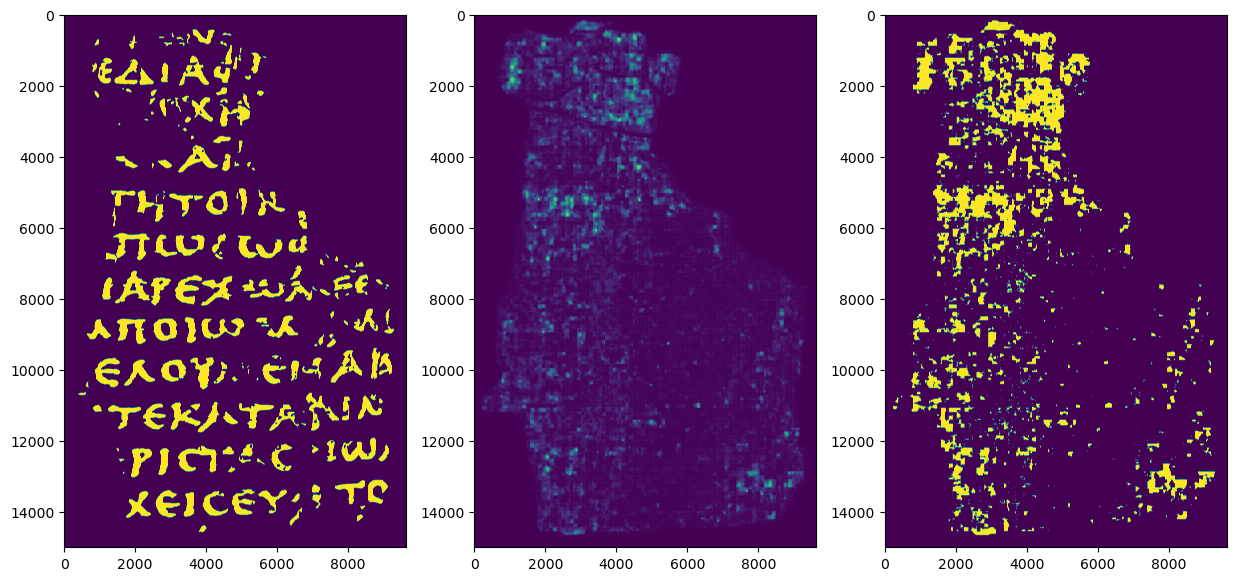

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([1.13873377e+08, 1.67050130e+07, 6.12992900e+06, 2.61228800e+06,
        1.54536400e+06, 1.11056700e+06, 7.59028000e+05, 5.25988000e+05,
        3.96259000e+05, 2.93606000e+05, 2.01444000e+05, 1.46740000e+05,
        1.07255000e+05, 7.54870000e+04, 4.45600000e+04, 2.26510000e+04,
        4.59400000e+03, 1.64000000e+03, 7.51000000e+02, 5.15000000e+02]),
 array([2.73467967e-05, 4.97830086e-02, 9.95386703e-02, 1.49294332e-01,
        1.99049994e-01, 2.48805656e-01, 2.98561317e-01, 3.48316979e-01,
        3.98072641e-01, 4.47828303e-01, 4.97583965e-01, 5.47339626e-01,
        5.97095288e-01, 6.46850950e-01, 6.96606612e-01, 7.46362273e-01,
        7.96117935e-01, 8.45873597e-01, 8.95629259e-01, 9.45384921e-01,
        9.95140582e-01]),
 <BarContainer object of 20 artists>)

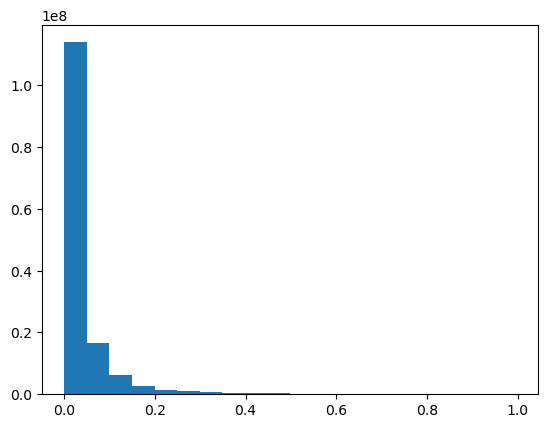

In [40]:
plt.hist(mask_pred.flatten(), bins=20)

In [41]:
# GPU VRAM 5.2GB/16.0GB A4000